In [174]:
import os
import re
import glob
import json
import torch
import pandas as pd
import pickle as pk
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from tqdm import tqdm

In [177]:
def make_metrics(metric, freqs):
    out = {}
    accs, preds = metric['per_class_accs'].numpy(), metric['per_class_pred_cnt'].numpy()
    Sw_invSb, cos_M_all, cos_W_all, cos_M_nearest, cos_W_nearest, cos_within \
        = metric['Sw_invSb'].numpy(), metric['cos_M_all'].numpy(), metric['cos_W_all'].numpy(), metric['cos_M_nearest'].numpy(), metric['cos_W_nearest'].numpy(), metric['cos_within'].numpy()
    corr_acc, corr_pred, corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within \
        = spearmanr(freqs, accs).statistic, spearmanr(freqs, preds).statistic, spearmanr(freqs, Sw_invSb).statistic, spearmanr(freqs, cos_M_all).statistic, \
          spearmanr(freqs, cos_W_all).statistic, spearmanr(freqs, cos_M_nearest).statistic, spearmanr(freqs, cos_W_nearest).statistic, spearmanr(freqs, cos_within).statistic
    corr_pred_acc, corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc \
        = spearmanr(accs, preds).statistic, spearmanr(accs, Sw_invSb).statistic, spearmanr(accs, cos_M_all).statistic, spearmanr(accs, cos_W_all).statistic, \
            spearmanr(accs, cos_M_nearest).statistic, spearmanr(accs, cos_W_nearest).statistic, spearmanr(accs, cos_within).statistic
    out['top1'], out['Sw_invSb'], out['cos_M'], out['cos_W'], out['cos_M_nearest'], out['cos_W_nearest'], out['cos_within'] \
        = accs.mean(), Sw_invSb.mean(), cos_M_all.mean(), cos_W_all.mean(), cos_M_nearest.mean(), cos_W_nearest.mean(), cos_within.mean()
    out['corr_acc'], out['corr_pred'], out['corr_Sw_invSb'], out['corr_cos_M_all'], out['corr_cos_W_all'], out['corr_cos_M_nearest'], out['corr_cos_W_nearest'], out['corr_cos_within'] \
        = corr_acc, corr_pred, corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within
    out['corr_pred_acc'], out['corr_Sw_invSb_acc'], out['corr_cos_M_all_acc'], out['corr_cos_W_all_acc'], out['corr_cos_M_nearest_acc'], out['corr_cos_W_nearest_acc'], out['corr_cos_within_acc'] \
        = corr_pred_acc, corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc
    return out

def get_float(path, key='thresh', return_str=False):
    if 'match_incap' in path:
        return '=freq'
    res = re.findall(r'{}\d+\.\d+'.format(key), path)
    if len(res) > 0:
        val = res[0].replace(key, '')
    else:
        val = str(1)
    if return_str:
        return val
    else: 
        return float(val)

def get_datasize(path):
    if 'incap' in path:
        startsn = re.findall(r'n\d+', path)
        if len(startsn) > 0:
            datasize = int(startsn[0].replace('n', ''))
            return datasize
    if 'laionet' in path:
        thresh = get_float(path, key='thresh', return_str=True) # if 'thresh' in path else '0.7'
        frac = get_float(path, key='frac', return_str=True) if 'frac' in path else '1'
        if thresh == '0.7':
            datasize = {'1':3256561, '0.5':1628287, '0.25':814158, '0.125':407100, '0.0625':203580, '0.03125':101848}[frac]
        else:
            datasize = {'0.7':3256561, '0.75':1925250, '0.8':879460, '0.82':576276, '0.85':260713, '0.88':88882, '0.9':36465, '=freq':416489}[thresh]
        return datasize
    return 448896

def get_head(path):
    if 'freezetext' in path or 'freezehead' in path:
        if 'wit400m' in path:
            return 'Frozen CLIP'
        elif 'roberta' in path:
            return 'Frozen RoBERTa'
        else:
            raise NotImplementedError
    elif 'inittext' in path:
        if 'wit400m' in path:
            return 'CLIP init'
        elif 'roberta' in path:
            return 'RoBERTa init'
        else:
            raise NotImplementedError
    else:
        return 'Rand init'

def get_freqs(path):
    if 'incap' in path:
        if 'laionet' in path:
            postfix = 'laionet_match_incap'
        else:
            postfix = 'incap_imagenet'
    elif 'laionet' in path:
        if 'supcls' in path:
            postfix = 'laionet_thresh0.7'
        else:
            splits = path.split('/')[-3].split('-')
            postfix = splits[-1] if 'laionet' in splits[-1] else splits[-2]
    else:
        postfix = 'incap_imagenet'
    freqs = pd.read_csv(f'../metadata/freqs/class_frequency_{postfix}_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
    return freqs

def get_metrics(paths):
    metrics = []
    for path in paths:
        if 'stats_val.jsonl' in path:
            path = path.replace('stats_val.jsonl', 'metrics/metrics_imagenet_zeroshot_val_latest.pt')
        if os.path.exists(path):
            df_dict = {}
            metric = torch.load(path, map_location='cpu')
            df_dict['Dataset'] = 'LAIONet' if 'laionet' in path else 'ImageNet-Captions'
            df_dict['Model'] = 'CLIP' if 'open_clip' in path else 'SL'
            df_dict['Text Head'] = get_head(path)
            df_dict['Threshold'] = get_float(path, 'thresh') # if 'thresh' in path else '0.7'
            df_dict['Data Size'] = get_datasize(path) / 1e6
            freqs = get_freqs(path)
            metric_dict = make_metrics(metric, freqs)
            df_dict.update(metric_dict)
            metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    metrics.loc[:, 'top1'] *= 100
    return metrics

freqs_incap = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs_incap = np.argsort(freqs_incap)[::-1]

freqs_laionet = pd.read_csv('../metadata/freqs/class_frequency_laionet_match_incap_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs_laionet = np.argsort(freqs_laionet)[::-1]

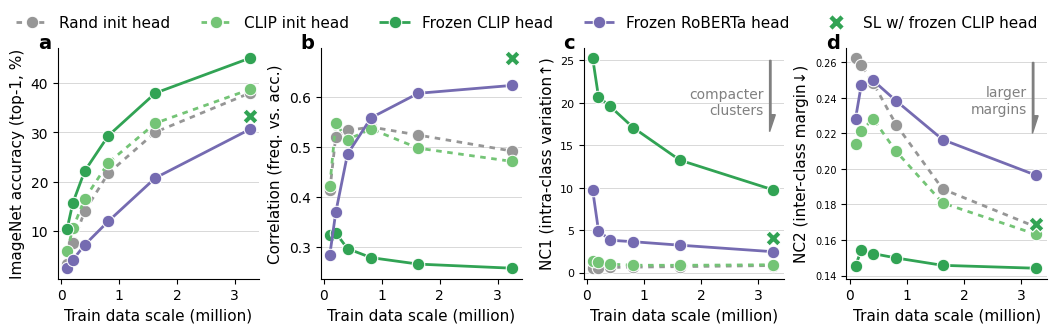

In [173]:
paths = [
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.5/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.25/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.125/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.0625/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.03125/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.5-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.25-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.125-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.0625-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.03125-freezetext_clip_wit400m/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7-inittext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.5-inittext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.25-inittext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.125-inittext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.0625-inittext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.03125-inittext_clip_wit400m/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7-freezetext_roberta/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.5-freezetext_roberta/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.25-freezetext_roberta/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.125-freezetext_roberta/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.0625-freezetext_roberta/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_frac0.03125-freezetext_roberta/stats_val.jsonl',

    '../exps_sup/output/rn50_laionet_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname/metrics/metrics_val_latest.pt',
]

metrics = get_metrics(paths)
metrics_clip = metrics[metrics['Model'] == 'CLIP']
metrics_sl = metrics[metrics['Model'] == 'SL']
palette = sns.color_palette('tab20c')
palette = [palette[-3], palette[9], palette[8], palette[12]]
markers = ['o', 'o', 'o', 'o']
dashes = [(2, 2), (1, 0), (2, 2), (1, 0)]
hue_order = ['Rand init', 'CLIP init', 'Frozen CLIP', 'Frozen RoBERTa']
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
sns.lineplot(metrics_clip, x='Data Size', y='top1', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[0], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=9)
sns.lineplot(metrics_clip, x='Data Size', y='corr_acc', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[1], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=9)
sns.lineplot(metrics_clip, x='Data Size', y='Sw_invSb', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[2], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=9)
sns.lineplot(metrics_clip, x='Data Size', y='cos_M', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[3], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=9)

sns.scatterplot(metrics_sl, x='Data Size', y='top1', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[0], palette=palette, markers='X', s=120, zorder=3)
sns.scatterplot(metrics_sl, x='Data Size', y='corr_acc', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[1], palette=palette, markers='X', s=120, zorder=3)
sns.scatterplot(metrics_sl, x='Data Size', y='Sw_invSb', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[2], palette=palette, markers='X', s=120, zorder=3)
sns.scatterplot(metrics_sl, x='Data Size', y='cos_M', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[3], palette=palette, markers='X', s=120, zorder=3)

ax[0].set_box_aspect(1.15)
ax[1].set_box_aspect(1.15)
ax[2].set_box_aspect(1.15)
ax[3].set_box_aspect(1.15)
ax[0].yaxis.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[1].yaxis.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[2].yaxis.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[3].yaxis.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[0].tick_params(axis='y', labelsize=10)
ax[1].tick_params(axis='y', labelsize=10)
ax[2].tick_params(axis='y', labelsize=8)
ax[3].tick_params(axis='y', labelsize=7)
# ax[0].set_ylim(ymin=-1)
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()
ax[3].legend().remove()

ax[0].text(-.1, 1, 'a', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-.1, 1, 'b', fontsize=14, fontweight='bold', transform=ax[1].transAxes)
ax[2].text(-.1, 1, 'c', fontsize=14, fontweight='bold', transform=ax[2].transAxes)
ax[3].text(-.1, 1, 'd', fontsize=14, fontweight='bold', transform=ax[3].transAxes)

ax[2].arrow(3.2, 25, 0, -6.4, width=.05, head_width=.2, head_length=2, fc='gray', ec='gray', shape='right')
ax[2].text(3.1, 18.3, 'compacter\nclusters', fontsize=10, color='gray', ha='right', va='bottom', rotation=0)
ax[3].arrow(3.2, .26, 0, -.03, width=.05, head_width=.2, head_length=.01, fc='gray', ec='gray', shape='right')
ax[3].text(3.1, .23, 'larger\nmargins', fontsize=10, color='gray', ha='right', va='bottom', rotation=0)

handles, labels = ax[3].get_legend_handles_labels()
labels = [label + ' head' for label in labels]
handles, labels = handles[:4] + [handles[6]], labels[:4] + ['SL w/ frozen CLIP head']
plt.legend(handles, labels, ncols=5, loc='upper left', bbox_to_anchor=(-4.2, 1.2), fontsize=11, frameon=False)

ax[0].set_xlabel('Train data scale (million)', fontsize=11)
ax[1].set_xlabel('Train data scale (million)', fontsize=11)
ax[2].set_xlabel('Train data scale (million)', fontsize=11)
ax[3].set_xlabel('Train data scale (million)', fontsize=11)
ax[0].set_ylabel('ImageNet accuracy (top-1, %)', fontsize=11)
ax[1].set_ylabel('Correlation (freq. vs. acc.)', fontsize=11)
ax[2].set_ylabel('NC1 (intra-class variation↑)', fontsize=11)
ax[3].set_ylabel('NC2 (inter-class margin↓)', fontsize=11)

plt.savefig('figs/laionet_scale.pdf', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/8z/bwhvzd4967b76fpt8fp9q9sr0000gn/T/ipykernel_43739/2060778273.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_laionet['thresh'] = metrics_laionet['Threshold'].map({t: i for i, t in enumerate(thresh)})


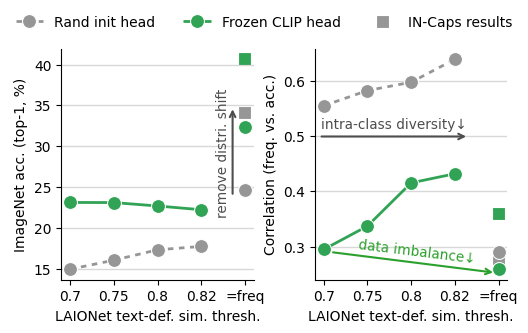

In [195]:
paths = [
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_n448896/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.75_n448896/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.8_n448896/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.82_n448896/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_match_incap/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.7_n448896-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.75_n448896-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.8_n448896-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_thresh0.82_n448896-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-laionet_match_incap-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m/stats_val.jsonl',
]


metrics = get_metrics(paths)
metrics_laionet = metrics[metrics['Dataset'] == 'LAIONet']
metrics_incap = metrics[metrics['Dataset'] == 'ImageNet-Captions']
palette = sns.color_palette('tab20c')
palette, palette_dark = [palette[-3], palette[8]], [palette[-4], palette[8]]
markers = ['o', 'o']
dashes = [(2, 2), (1, 0)]
hue_order = ['Rand init', 'Frozen CLIP']
thresh = metrics_laionet['Threshold'].unique()
metrics_laionet['thresh'] = metrics_laionet['Threshold'].map({t: i for i, t in enumerate(thresh)})
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.lineplot(metrics_laionet[metrics_laionet['Threshold'] != '=freq'], x='thresh', y='top1', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[0], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=10)
sns.lineplot(metrics_laionet[metrics_laionet['Threshold'] != '=freq'], x='thresh', y='corr_acc', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[1], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=10)
sns.lineplot(metrics_laionet[metrics_laionet['Threshold'] == '=freq'], x='thresh', y='top1', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[0], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=10)
sns.lineplot(metrics_laionet[metrics_laionet['Threshold'] == '=freq'], x='thresh', y='corr_acc', hue='Text Head', hue_order=hue_order, style='Text Head', ax=ax[1], palette=palette, markers=markers, dashes=dashes, linewidth=2, markersize=10)

top1_rand = metrics_incap[metrics_incap['Text Head'] == 'Rand init']['top1'].values[0]
top1_freeze = metrics_incap[metrics_incap['Text Head'] == 'Frozen CLIP']['top1'].values[0]
corr_rand = metrics_incap[metrics_incap['Text Head'] == 'Rand init']['corr_acc'].values[0]
corr_freeze = metrics_incap[metrics_incap['Text Head'] == 'Frozen CLIP']['corr_acc'].values[0]

ax[0].scatter(x=4, y=top1_rand, color=palette[0], marker='s', s=65, ec='w', lw=.1, label='IN-Caps model', zorder=0)
ax[0].scatter(x=4, y=top1_freeze, color=palette[1], marker='s', s=65, ec='w', lw=.1, label='IN-Caps model', zorder=0)
ax[1].scatter(x=4, y=corr_rand, color=palette[0], marker='s', s=65, ec='w', lw=.1, label='IN-Caps model', zorder=0)
ax[1].scatter(x=4, y=corr_freeze, color=palette[1], marker='s', s=65, ec='w', lw=.1, zorder=0)

ax[0].set_box_aspect(1.2)
ax[1].set_box_aspect(1.2)
ax[0].yaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
ax[1].yaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].legend().remove()
ax[1].legend().remove()
handles, labels = ax[1].get_legend_handles_labels()
handles, labels = [handles[0], handles[1], handles[-1]], [labels[0], labels[1], labels[-1]]
labels[0] = 'Rand init head'
labels[1] = 'Frozen CLIP head'
labels[2] = 'IN-Caps results'
plt.legend(handles, labels, ncols=3, loc='upper left', bbox_to_anchor=(-1.62, 1.2), fontsize=10, frameon=False)

ax[0].set_xticks(range(len(thresh)), labels=thresh)
ax[1].set_xticks(range(len(thresh)), labels=thresh)
ax[0].tick_params(axis='y', labelsize=10)
ax[1].tick_params(axis='y', labelsize=10)
ax[0].set_xlabel('LAIONet text-def. sim. thresh.', fontsize=10)
ax[1].set_xlabel('LAIONet text-def. sim. thresh.', fontsize=10)
ax[0].set_ylabel('ImageNet acc. (top-1, %)', fontsize=10)
ax[1].set_ylabel('Correlation (freq. vs. acc.)', fontsize=10)

ax[0].text(.84, .55, 'remove distri. shift', ha='center', va='center', fontsize=9.8, transform=ax[0].transAxes, color='0.3', rotation=90)
ax[0].annotate('', xy=(.89, .36), xytext=(.89, .75), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='0.3'))
ax[1].text(1.73, .67, 'intra-class diversity↓', ha='center', va='center', fontsize=9.8, transform=ax[0].transAxes, color='0.3')
ax[1].annotate('', xy=(.02, .62), xytext=(.8, .62), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='0.3'))
ax[1].text(1.85, .12, 'data imbalance↓', ha='center', va='center', fontsize=9.8, transform=ax[0].transAxes, color='tab:green', rotation=-7)
ax[1].annotate('', xy=(.08, .12), xytext=(.94, .03), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', lw=1.5, color='tab:green'))

plt.savefig('figs/laionet_thresh.pdf', bbox_inches='tight', dpi=300)
plt.show()